In [64]:
import matplotlib.pyplot as plt
from joblib import load, dump
import pandas as pd
import numpy as np
import warnings, os

import seaborn as sns
import scipy.stats as stats
import tensorflow as tf

import aggmap
from aggmap import loadmap

warnings.filterwarnings("ignore")
sns.set(style= 'white',font_scale = 1.2)

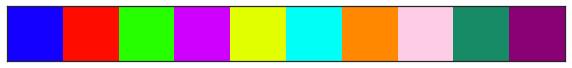

In [65]:
color_list = ['#1300ff','#ff0c00','#25ff00', '#d000ff','#e2ff00', 
              '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'] #colors for different channels
sns.palplot(color_list)

In [66]:
def imshow(x_arr,  ax,  color_list = ['#1300ff','#ff0c00','#25ff00', '#d000ff','#e2ff00', 
                                      '#00fff6', '#ff8800', '#fccde5','#178b66', '#8a0075'], x_max = 255, vmin = 0, vmax = 1,):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list) >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'
        
    
    cmaps = [sns.light_palette(color, n_colors =  100, reverse=False) for color in color_list]

    for i in range(c):
        data = x[:,:,i]/x_max
        sns.heatmap(data, cmap = cmaps[i],  vmin = vmin, vmax = vmax,  
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax, ) # linewidths=0.005, linecolor = '0.9'

    sns.heatmap(xxx, vmin=0, vmax=1, cmap = 'Greys', yticklabels=False, xticklabels=False, cbar=False, ax=ax)
    #-100000
    
    color = 'black'
    lw = 1.5
    
    ax.axhline(y=0, color=color,lw=lw, ls =  '--')
    ax.axhline(y=data.shape[0], color=color,lw=lw, ls =  '--')
    
    ax.autoscale()
    ax.axvline(x=0, color=color,lw=lw, ls =  '--')
    ax.axvline(x=data.shape[1], color=color,lw=lw, ls =  '--')  



def imshow_wrap(x):
    fig, ax = plt.subplots(figsize=(4,4))
    imshow(x.astype(float), ax=ax, x_max = 255, vmin = -0.001, vmax=1)
    

def tracked_orignal_change(orignal_image, new_mp):
    
    #mp = mp_ORSAggS4
    #orignal_image = trainX_OR1[0]
    df = new_mp._S.df.copy()
    SI = df.groupby('Subtypes').apply(lambda x:x.index.to_list())
    M, N, C = orignal_image.shape
    v = orignal_image.reshape(M*N*C, )
    arr_res = []
    for i, j in SI.items():
        j = [int(k.replace('p-',''))-1 for k in j]
        arr_1d = np.zeros(M*N, )
        arr_1d[j] = v[j]
        arr = arr_1d.reshape(M, N)  
        arr_res.append(arr)
    arr_tracked = np.stack(arr_res, axis=-1)
    return arr_tracked



In [67]:
data_save_folder = '/raid/shenwanxiang/aggmap/fmnist/correlation/'

results_save_folder = './imgs'

if not os.path.exists(results_save_folder):
    os.makedirs(results_save_folder)

mp_train = loadmap(os.path.join(data_save_folder, 'train.mp'))
mp_test = loadmap(os.path.join(data_save_folder, 'test.mp'))


In [68]:
mp_train.info_distance.max()

1.6577623419656602

# 1. plot feature distances

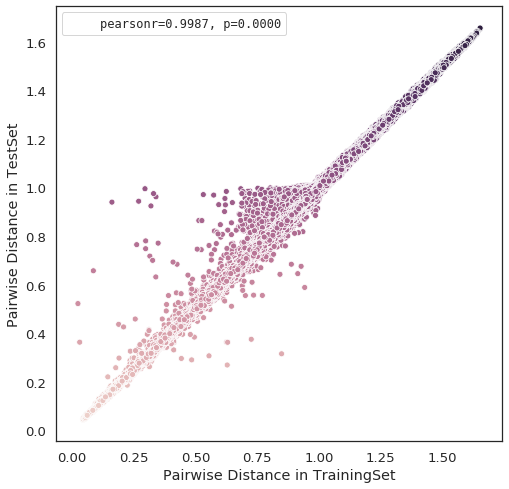

In [69]:
fig, ax = plt.subplots(figsize=(8,8))

tr = 'Pairwise Distance in TrainingSet'
ts = 'Pairwise Distance in TestSet'

df = pd.DataFrame(mp_test.info_distance, index = mp_train.info_distance, 
                  columns = [tr])
df.index.name = ts
df = df.reset_index()
df = df[~((df[tr] == 0) | (df[ts] == 0))] 

r,p = stats.pearsonr(df[tr], df[ts])
annot_kws = {'prop':{'family':'monospace',  'size':12}}
#g = sns.jointplot(x=tr, y=ts, data=df, kind='reg') # Scatter and regression all green joint_kws={'color':'green'}
sns.scatterplot(x=tr, y=ts, data=df, ax=ax, hue = ts)

phantom, = ax.plot([], [], linestyle="", alpha=0)

ax.legend([phantom],['pearsonr=%.4f, p=%.4f' % (r,p)], **annot_kws)
# plt.yscale('log')
# plt.xscale('log')
plt.savefig(os.path.join(results_save_folder, '00_tr_ts_dist.png'), bbox_inches='tight', dpi=300)

# 2. plot feature types

In [70]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() #(x_train, y_train), (x_test, y_test)
mnist_labels_dict = {0: 'T-shirt/top',1: 'Trouser',2: 'Pullover',
                     3: 'Dress',4: 'Coat', 5: 'Sandal', 
                     6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
seed = 88

In [71]:
label_idxs = pd.Series(y_train).to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())

In [72]:
label_idxs

labels
0    [1, 2, 4, 10, 17, 26, 34, 48, 61, 64, 66, 67, ...
1    [16, 21, 38, 69, 71, 74, 78, 80, 86, 97, 98, 1...
2    [5, 7, 27, 37, 45, 53, 54, 65, 92, 123, 124, 1...
3    [3, 20, 25, 31, 47, 49, 50, 51, 58, 59, 70, 73...
4    [19, 22, 24, 28, 29, 68, 75, 76, 96, 117, 128,...
5    [8, 9, 12, 13, 30, 36, 43, 60, 62, 63, 82, 116...
6    [18, 32, 33, 39, 40, 55, 56, 72, 77, 95, 104, ...
7    [6, 14, 41, 46, 52, 83, 85, 87, 108, 119, 126,...
8    [23, 35, 57, 99, 100, 105, 109, 110, 130, 144,...
9    [0, 11, 15, 42, 44, 79, 84, 88, 89, 90, 93, 10...
dtype: object

In [83]:
X_OR1 = load(os.path.join(data_save_folder, '01_X_OR1.data'))
X_ORS1 = load(os.path.join(data_save_folder, '02_X_ORS1.data'))
X_ORSAgg1 = load(os.path.join(data_save_folder, '03_X_ORSAgg1.data'))
X_ORSAggC3 = load(os.path.join(data_save_folder, '03_X_ORSAggC3.data'))
X_ORSAggC5 = load(os.path.join(data_save_folder, '04_X_ORSAggC5.data'))
X_ORSAggC10 = load(os.path.join(data_save_folder, '05_X_ORSAggC10.data'))

In [84]:
fmp_types = [X_OR1,  X_ORS1,  X_ORSAgg1, X_ORSAggC3, X_ORSAggC5, X_ORSAggC10]

In [85]:
mp_ORSAgg1 = loadmap(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
mp_ORSAggC3 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC3.mp'))
mp_ORSAggC5 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC5.mp'))
mp_ORSAggC10 = loadmap(os.path.join(data_save_folder, 'mp_ORSAggC10.mp'))

### 2.1 plot feature maps for all classes

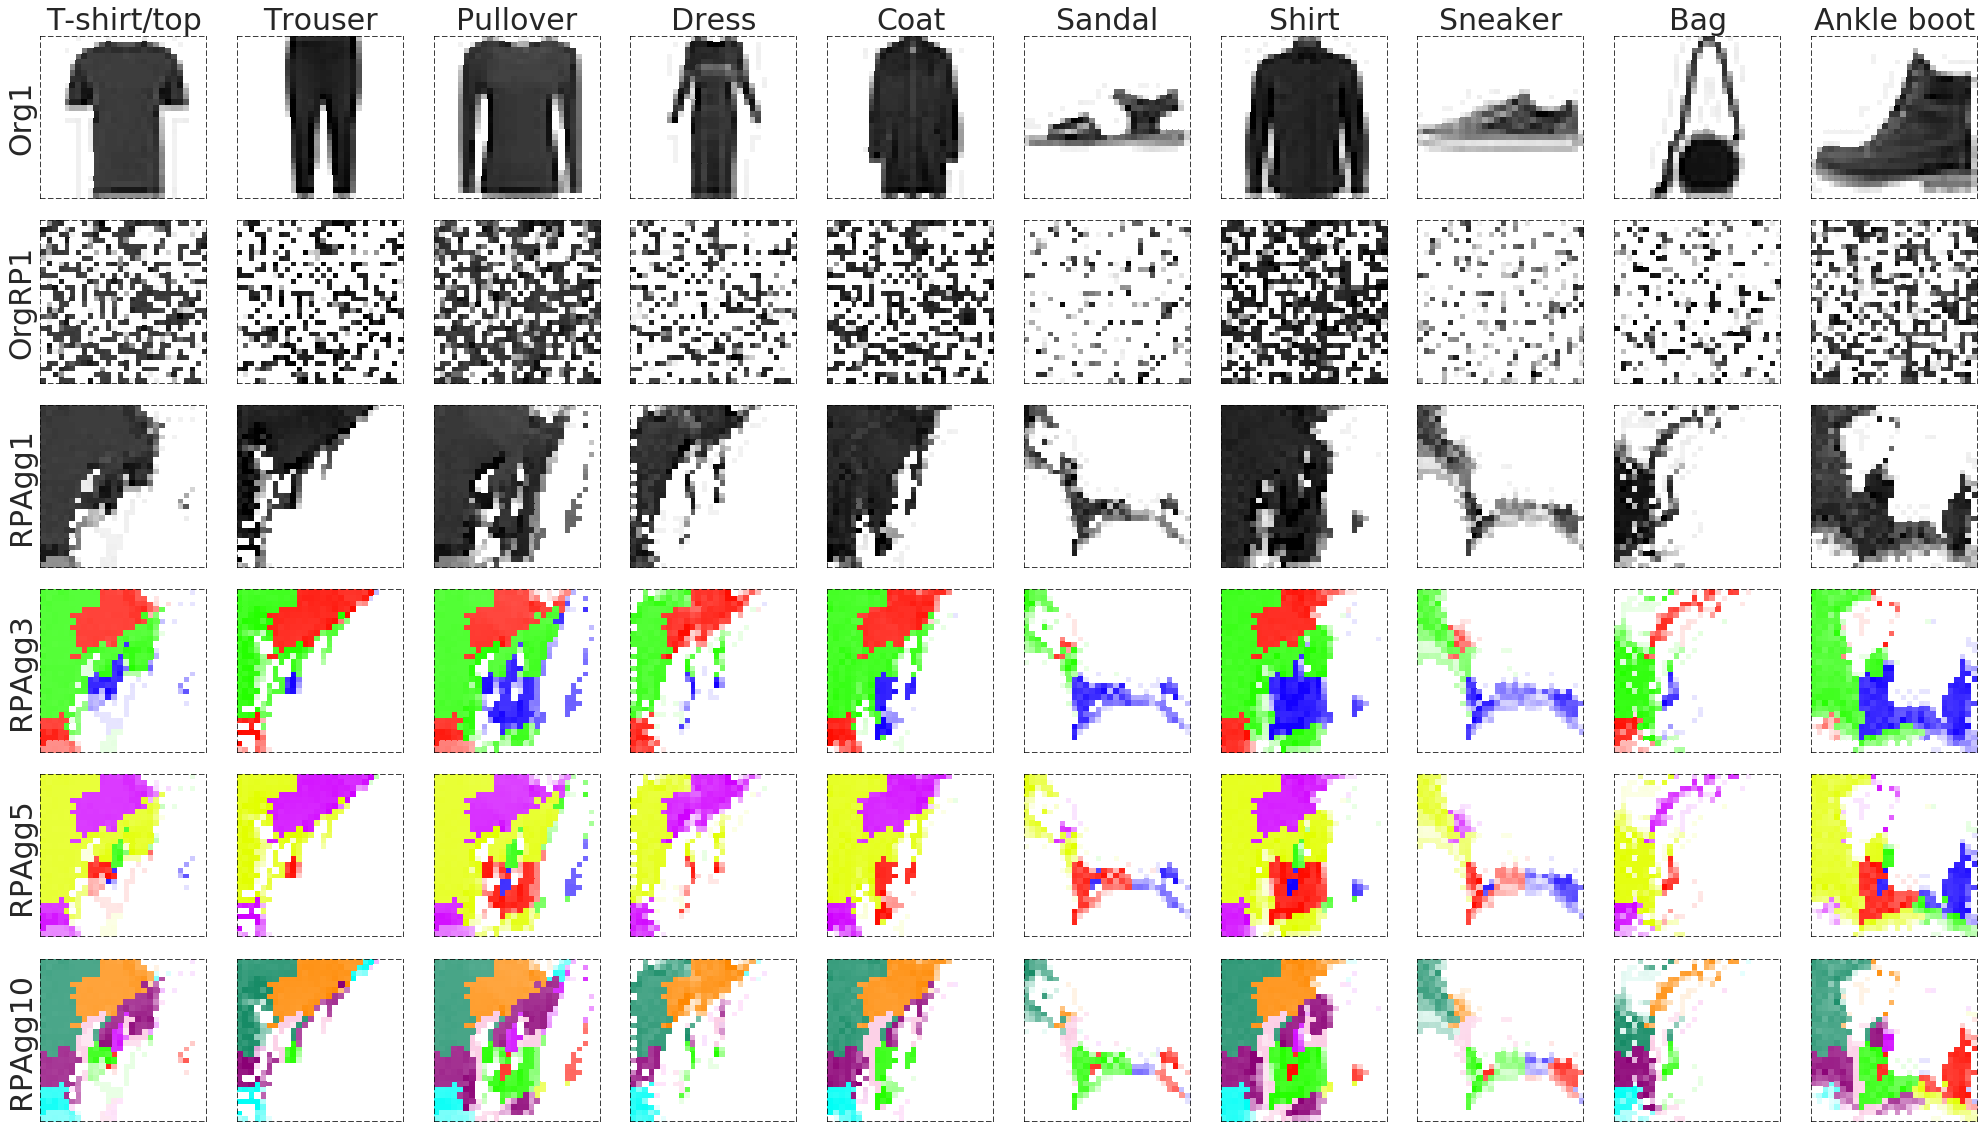

In [90]:
rows = ['Org1', 'OrgRP1', 'RPAgg1', 'RPAgg3', 'RPAgg5', 'RPAgg10']
cols = list(mnist_labels_dict.values())

image_idx = [pd.Series(label_idxs[i][:100]).sample(1, random_state = seed).to_list()[0] for i in range(len(label_idxs))]
cols = [i for i,j in zip(cols, image_idx)] #i + '-%s' % j

fig, axes = plt.subplots(nrows=6, ncols=10, figsize=(28,16), sharex = True, sharey = True)

fontsize = 30
## plot transformed images
for axc, X in zip(axes[:6], fmp_types):
    for ax, idx in zip(axc, image_idx):
        x = X[0][idx].astype(float)
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'], vmin = 0)
            #ax.imshow(x.reshape((x.shape[0],x.shape[1])), cmap=plt.cm.Greys)
        else:
            imshow(x, ax=ax, color_list = color_list, vmin = 0)
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': fontsize})
    
for ax, row in zip(axes[:6,0], rows):
    ax.set_ylabel(row, fontsize = fontsize)    
 
    
fig.tight_layout()
#fig.savefig(os.path.join(results_save_folder, 'featuremaps_00_10_classes.svg'), bbox_inches='tight', dpi=300) 
#fig.savefig(os.path.join(results_save_folder, 'featuremaps_00_10_classes.pdf'), bbox_inches='tight', dpi=300) 
fig.savefig(os.path.join(results_save_folder, 'featuremaps_00_10_classes.png'), bbox_inches='tight', dpi=400) 

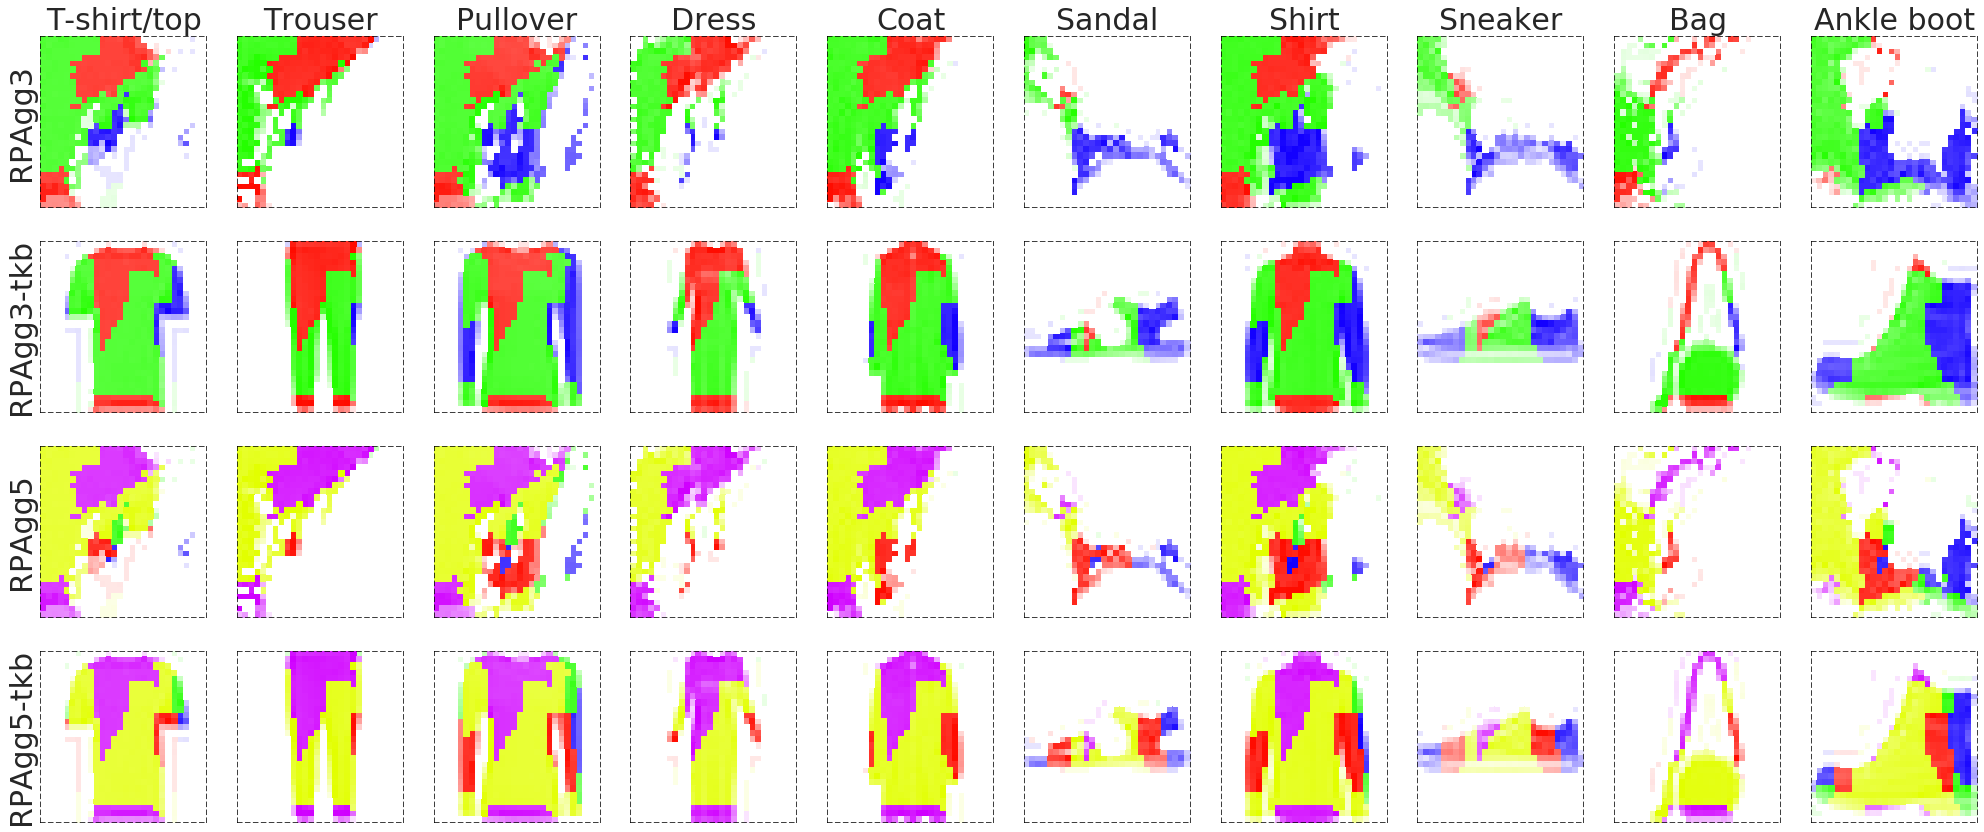

In [77]:
## plot tracked back images

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(28,12), sharex = True, sharey = True)

fmp_types = [X_ORSAggC3]
for axc, X in zip(axes[:1], fmp_types):
    for ax, idx in zip(axc, image_idx):
        x = X[0][idx].astype(float)
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'])
        else:
            imshow(x, ax=ax, color_list = color_list)
            
for ax, row in zip(axes[:1,0], ['RPAgg3']):
    ax.set_ylabel(row, fontsize = fontsize) 
    
    
mps = [mp_ORSAggC3]
cols_name = ['RPAgg3-tkb']
for axc, mp in zip(axes[1:2], mps):
    for ax, idx in zip(axc, image_idx):
        x = tracked_orignal_change(X_OR1[0][idx], mp)
        imshow(x, ax=ax, color_list = color_list)

for ax, row in zip(axes[1:2,0], cols_name):
    ax.set_ylabel(row, fontsize = fontsize)  
    
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontdict = {'fontsize': fontsize})


fmp_types = [X_ORSAggC5]
for axc, X in zip(axes[2:3], fmp_types):
    for ax, idx in zip(axc, image_idx):
        x = X[0][idx].astype(float)
        if x.shape[-1] == 1:
            imshow(x, ax=ax, color_list = ['black'])
        else:
            imshow(x, ax=ax, color_list = color_list)
            
for ax, row in zip(axes[2:3,0], ['RPAgg5']):
    ax.set_ylabel(row, fontsize = fontsize) 
    
    
mps = [mp_ORSAggC5]
cols_name = ['RPAgg5-tkb']
for axc, mp in zip(axes[3:4], mps):
    for ax, idx in zip(axc, image_idx):
        x = tracked_orignal_change(X_OR1[0][idx], mp)
        imshow(x, ax=ax, color_list = color_list)

for ax, row in zip(axes[3:4,0], cols_name):
    ax.set_ylabel(row, fontsize = fontsize)  

fig.tight_layout()
fig.savefig(os.path.join(results_save_folder, 'featuremaps_01_tkb.png'), bbox_inches='tight', dpi=400) 

### 2.2 plot feature maps for each class

In [78]:
# rows = ['Org1', 'OrgRP1', 'RPAgg1', 'RPAgg3', 'RPAgg5']
# for label, label_name in mnist_labels_dict.items():
#     image_idx = pd.Series(label_idxs[label][:100]).sample(6, random_state = seed).tolist()
#     cols = [label_name + '-%s' % i for i in image_idx]
#     fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(22,20), sharex = True, sharey = True)
#     for axc, X in zip(axes, fmp_types):
#         for ax, idx in zip(axc, image_idx):
#             x = X[0][idx].astype(float)
#             imshow(x, ax=ax)
#     for ax, col in zip(axes[0], cols):
#         ax.set_title(col, fontdict = {'fontsize': fontsize})
#     for ax, row in zip(axes[:,0], rows):
#         ax.set_ylabel(row, fontsize = fontsize)    
#     fig.tight_layout()
#     fig.savefig(os.path.join(results_save_folder, 'featuremaps_01_%s.png' % str(label).zfill(2)), bbox_inches='tight', dpi=300)

### 2.2 plot feature map objects

In [79]:
mp_ORSAgg1.plot_grid(htmlpath = results_save_folder, htmlname = 'mp_ORSAgg1_grid.html')
mp_ORSAgg1.plot_scatter(htmlpath = results_save_folder, htmlname = 'mp_ORSAgg1_scatter.html', radius=5)

2020-10-15 22:47:25,739 - INFO - [bidd-aggmap] - generate file: ./imgs/mp_ORSAgg1_grid.html_feature points_784_correlation_umap_mp
2020-10-15 22:47:25,757 - INFO - [bidd-aggmap] - save html file to ./imgs/mp_ORSAgg1_grid.html_feature points_784_correlation_umap_mp
2020-10-15 22:47:25,758 - INFO - [bidd-aggmap] - generate file: ./imgs/mp_ORSAgg1_scatter.html_feature points_784_correlation_umap_scatter
2020-10-15 22:47:25,774 - INFO - [bidd-aggmap] - save html file to ./imgs/mp_ORSAgg1_scatter.html_feature points_784_correlation_umap_scatter


2020-10-15 22:47:25,789 - INFO - [bidd-aggmap] - generate file: ./imgs/mp_ORSAggC5_scatter.html_feature points_784_correlation_umap_scatter
2020-10-15 22:47:25,810 - INFO - [bidd-aggmap] - save html file to ./imgs/mp_ORSAggC5_scatter.html_feature points_784_correlation_umap_scatter
2020-10-15 22:47:25,811 - INFO - [bidd-aggmap] - generate file: ./imgs/mp_ORSAggC5_grid.html_feature points_784_correlation_umap_mp
2020-10-15 22:47:25,830 - INFO - [bidd-aggmap] - save html file to ./imgs/mp_ORSAggC5_grid.html_feature points_784_correlation_umap_mp


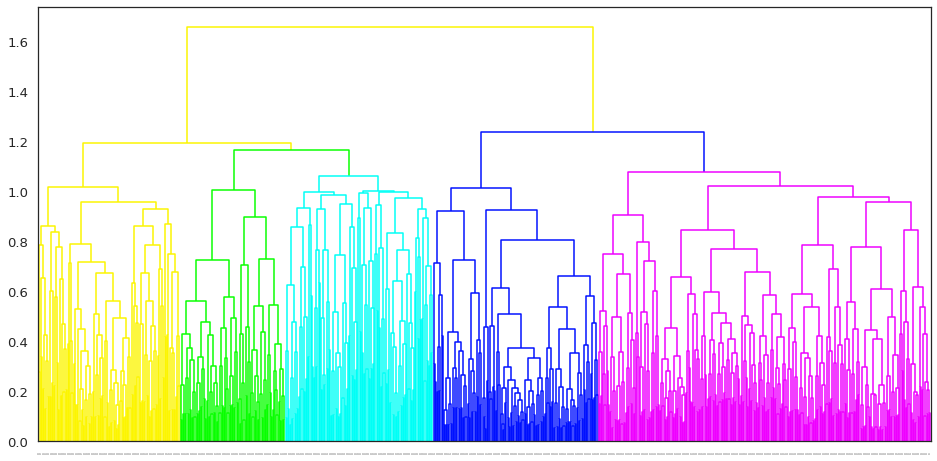

In [80]:
mp_ORSAggC5.plot_scatter(htmlpath = results_save_folder, htmlname = 'mp_ORSAggC5_scatter.html', radius=5 )
mp_ORSAggC5.plot_grid(htmlpath = results_save_folder, htmlname = 'mp_ORSAggC5_grid.html')
fig = mp_ORSAggC5.plot_tree(leaf_font_size = 1)
fig.savefig(os.path.join(results_save_folder, 'mp_ORSAggC5_tree.png'), bbox_inches='tight', dpi=300)

2020-10-15 22:48:02,899 - INFO - [bidd-aggmap] - generate file: ./imgs/mp_ORSAggC3_scatter.html_feature points_784_correlation_umap_scatter
2020-10-15 22:48:02,921 - INFO - [bidd-aggmap] - save html file to ./imgs/mp_ORSAggC3_scatter.html_feature points_784_correlation_umap_scatter
2020-10-15 22:48:02,921 - INFO - [bidd-aggmap] - generate file: ./imgs/mp_ORSAggC3_grid.html_feature points_784_correlation_umap_mp
2020-10-15 22:48:02,939 - INFO - [bidd-aggmap] - save html file to ./imgs/mp_ORSAggC3_grid.html_feature points_784_correlation_umap_mp


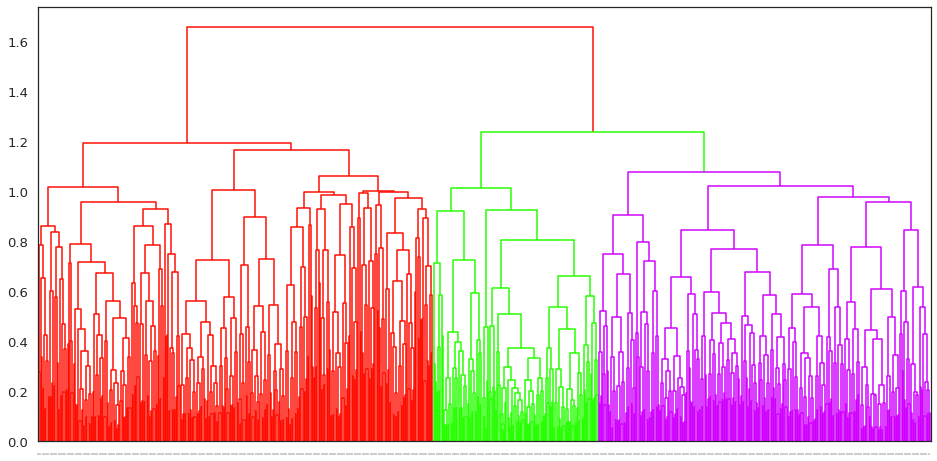

In [81]:
mp_ORSAggC3.plot_scatter(htmlpath = results_save_folder, htmlname = 'mp_ORSAggC3_scatter.html', radius=5 )
mp_ORSAggC3.plot_grid(htmlpath = results_save_folder, htmlname = 'mp_ORSAggC3_grid.html')
fig = mp_ORSAggC3.plot_tree(leaf_font_size = 1)
fig.savefig(os.path.join(results_save_folder, 'mp_ORSAggC3_tree.png'), bbox_inches='tight', dpi=400)